## Limpieza de la base de datos del AÑO 2022

In [5]:
#Cargar base de datos
datos_orig2022 = pd.read_csv("CONTAMINANTES_CIUDAD_DE_MEXICO2022.csv")
datos_orig2022.head()

,FECHA,HORA,O3,NO2,NOX,NO,SO2,CO
0,01/01/2022,1,3,44,55,11,3,1.08
1,01/01/2022,2,2,47,77,29,3,1.48
2,01/01/2022,3,2,46,79,33,3,1.67
3,01/01/2022,4,1,44,66,21,2,1.22
4,01/01/2022,5,1,41,72,31,2,1.40


In [6]:
datos_orig2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FECHA   8760 non-null   object 
 1   HORA    8760 non-null   int64  
 2   O3      8760 non-null   int64  
 3   NO2     8760 non-null   int64  
 4   NOX     8760 non-null   int64  
 5   NO      8760 non-null   int64  
 6   SO2     8760 non-null   int64  
 7   CO      8760 non-null   float64
dtypes: float64(1), int64(6), object(1)
memory usage: 547.6+ KB


In [23]:
# Crear una COPIA del DataFrame original para trabajar
df_estudio = datos_orig2022.copy()

df_estudio.replace(-99, np.nan, inplace=True) #remplazar -99 por NAN

In [24]:
df_estudio.isnull().sum()

,0
FECHA,0
HORA,0
O3,462
NO2,789
NOX,789
NO,789
SO2,1093
CO,616


In [26]:
faltanteO3 = df_estudio['O3'].isnull().sum()
faltanteNO2 = df_estudio['NO2'].isnull().sum()
faltanteCO = df_estudio['CO'].isnull().sum()
faltanteSO2 = df_estudio['SO2'].isnull().sum()
faltanteNOX = df_estudio['NOX'].isnull().sum()
faltanteNO = df_estudio['NO'].isnull().sum()

print(f'Faltantes O3: {faltanteO3}')
print(f'Faltantes NO2: {faltanteNO2}')
print(f'Faltantes CO: {faltanteCO}')
print(f'Faltantes SO2: {faltanteSO2}')
print(f'Faltantes NOX: {faltanteNOX}')
print(f'Faltantes NO: {faltanteNO}')

Faltantes O3: 462
Faltantes NO2: 789
Faltantes CO: 616
Faltantes SO2: 1093
Faltantes NOX: 789
Faltantes NO: 789


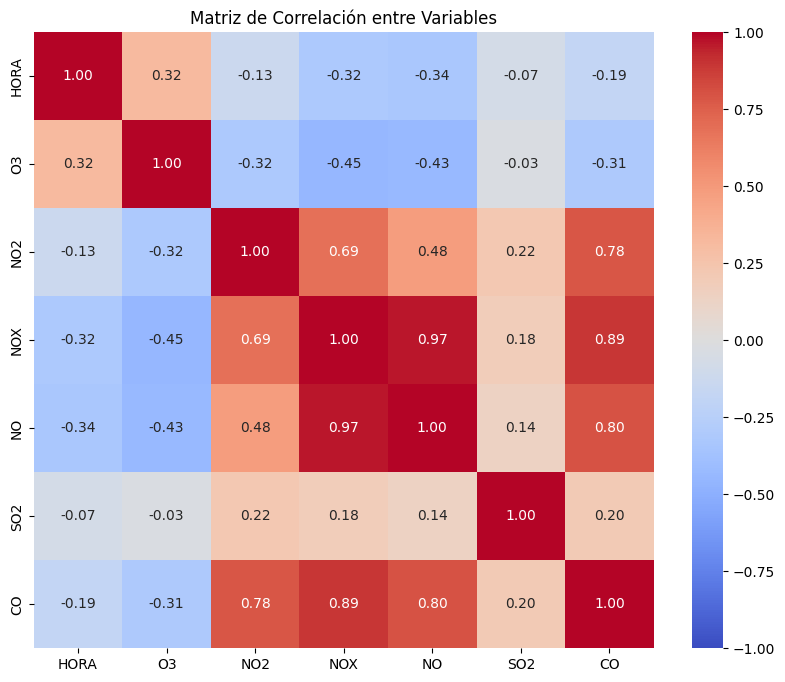

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación (usando Pearson)

columnas_numericas = ['HORA', 'O3', 'NO2', 'NOX', 'NO', 'SO2', 'CO']
correlacion = df_estudio[columnas_numericas].corr()

# Crear un heatmap interactivo
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Matriz de Correlación entre Variables")
plt.show()

Observamos que S02 no tiene una gran correlación en entre nuestras variables, además que las variables NO2, NOX, NO y CO son las más correlacionadas.

In [32]:

# Usaremos una imputación temporal medida por hora y el método de K-vecinos

from sklearn.impute import KNNImputer

# Variables correlacionadas + HORA (para contexto temporal)


variables_correlacionadas = ["NO", "NOX", "NO2", "CO", "HORA"]
imputador_knn = KNNImputer(n_neighbors=5)

# Aplicar imputación
df_imputado_knn2022 = pd.DataFrame(
    imputador_knn.fit_transform(df_estudio[variables_correlacionadas]),
    columns=variables_correlacionadas,
    index=df_estudio.index # Asegura que df_imputado_knn tenga el mismo índice que df_estudio
)

#Agregar FECHA
df_imputado_knn2022["FECHA"] = df_estudio["FECHA"]

# Agrupa por hora y calcular la mediana de SO2 para cada hora
mediana_so2_por_hora = df_estudio.groupby("HORA")["SO2"].transform("median")
# Imputar SO2 usando la mediana horaria
df_imputado_knn2022["SO2"] = df_estudio["SO2"].fillna(mediana_so2_por_hora)
# Si aún quedan NaN, usar la mediana global
df_imputado_knn2022["SO2"] = df_imputado_knn2022["SO2"].fillna(df_imputado_knn2022["SO2"].median())


# Si O3 tiene correlaciones moderadas, usar KNN con variables relacionadas
mediana_o3_por_hora = df_estudio.groupby("HORA")["O3"].transform("median")
df_imputado_knn2022["O3"] = df_estudio["O3"].fillna(mediana_o3_por_hora)

In [34]:

faltanteO3 = df_imputado_knn2022['O3'].isnull().sum()
faltanteNO2 = df_imputado_knn2022['NO2'].isnull().sum()
faltanteCO = df_imputado_knn2022['CO'].isnull().sum()
faltanteSO2 = df_imputado_knn2022['SO2'].isnull().sum()
faltanteNOX = df_imputado_knn2022['NOX'].isnull().sum()
faltanreNO = df_imputado_knn2022['NO'].isnull().sum()


print(f'Faltantes O3: {faltanteO3}')
print(f'Faltantes NO2: {faltanteNO2}')
print(f'Faltantes CO: {faltanteCO}')
print(f'Faltantes SO2: {faltanteSO2}')
print(f'Faltantes NOX: {faltanteNOX}')
print(f'Faltantes NO: {faltanreNO}')

Faltantes O3: 0
Faltantes NO2: 0
Faltantes CO: 0
Faltantes SO2: 0
Faltantes NOX: 0
Faltantes NO: 0


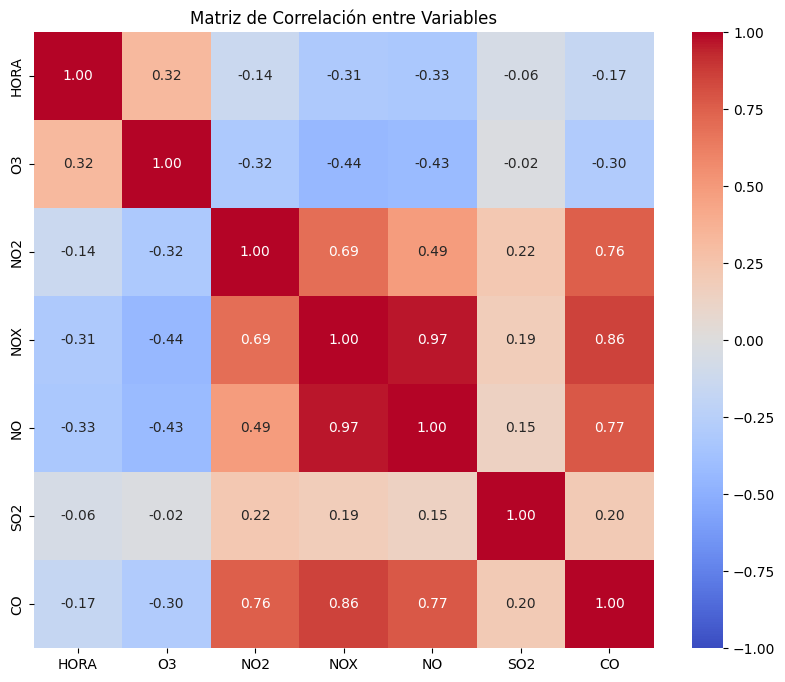

In [35]:
# Calcular la matriz de correlación
correlacion = df_imputado_knn2022[['HORA', 'O3', 'NO2', 'NOX','NO', 'SO2', 'CO']].corr()

# Crear un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Matriz de Correlación entre Variables")
plt.show()

In [42]:
columnas_ordenadas = ["FECHA"] + variables_correlacionadas + ["SO2", "O3"]
df_imputado_knn2022 = df_imputado_knn2022[columnas_ordenadas]

In [47]:
#Descargar base de datos ya limpia de los contaminates del año 2022 de la Ciudad de México

df_imputado_knn2022.to_csv('CONTAMINATES_BASELIMPIA_2022.csv', index=False, encoding='utf-8')


## Limpieza de la base de datos del AÑO 2023

In [48]:
# Cargar los datos
datos_orig = pd.read_csv('CONTAMIANTES_CIUDAD_MEXICO.csv')
datos_orig.head()

,FECHA,HORA,O3,NO2,NOX,NO,SO2,CO,PM10,PM25,PMCO
0,01/01/2023,1,2,36,63,26,1,1.2,-99,-99,-99
1,01/01/2023,2,4,32,45,13,1,1.0,-99,-99,-99
2,01/01/2023,3,4,30,52,22,2,1.2,-99,-99,-99
3,01/01/2023,4,2,28,55,26,2,1.1,-99,-99,-99
4,01/01/2023,5,2,27,71,44,2,1.3,-99,-99,-99


In [49]:
## Hacer una limpieza de datos

# Crear una COPIA del DataFrame original para trabajar
df_estudio = datos_orig.copy()

df_estudio.replace(-99, np.nan, inplace=True) #remplazar -99 por NAN

df_estudio = df_estudio.drop(['PM10', 'PM25', 'PMCO'], axis=1) #eliminar col comp por NAN
df_estudio.head()

,FECHA,HORA,O3,NO2,NOX,NO,SO2,CO
0,01/01/2023,1,2.0,36.0,63.0,26.0,1.0,1.2
1,01/01/2023,2,4.0,32.0,45.0,13.0,1.0,1.0
2,01/01/2023,3,4.0,30.0,52.0,22.0,2.0,1.2
3,01/01/2023,4,2.0,28.0,55.0,26.0,2.0,1.1
4,01/01/2023,5,2.0,27.0,71.0,44.0,2.0,1.3


In [50]:
df_estudio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5088 entries, 0 to 5087
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FECHA   5088 non-null   object 
 1   HORA    5088 non-null   int64  
 2   O3      4977 non-null   float64
 3   NO2     4880 non-null   float64
 4   NOX     4880 non-null   float64
 5   NO      4880 non-null   float64
 6   SO2     3676 non-null   float64
 7   CO      4957 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 318.1+ KB


In [51]:
faltanteO3 = df_estudio['O3'].isnull().sum()
faltanteNO2 = df_estudio['NO2'].isnull().sum()
faltanteCO = df_estudio['CO'].isnull().sum()
faltanteSO2 = df_estudio['SO2'].isnull().sum()
faltanteNOX = df_estudio['NOX '].isnull().sum()

print(f'Faltantes O3: {faltanteO3}')
print(f'Faltantes NO2: {faltanteNO2}')
print(f'Faltantes CO: {faltanteCO}')
print(f'Faltantes SO2: {faltanteSO2}')
print(f'Faltantes NOX: {faltanteNOX}')


Faltantes O3: 111
Faltantes NO2: 208
Faltantes CO: 131
Faltantes SO2: 1412
Faltantes NOX: 208


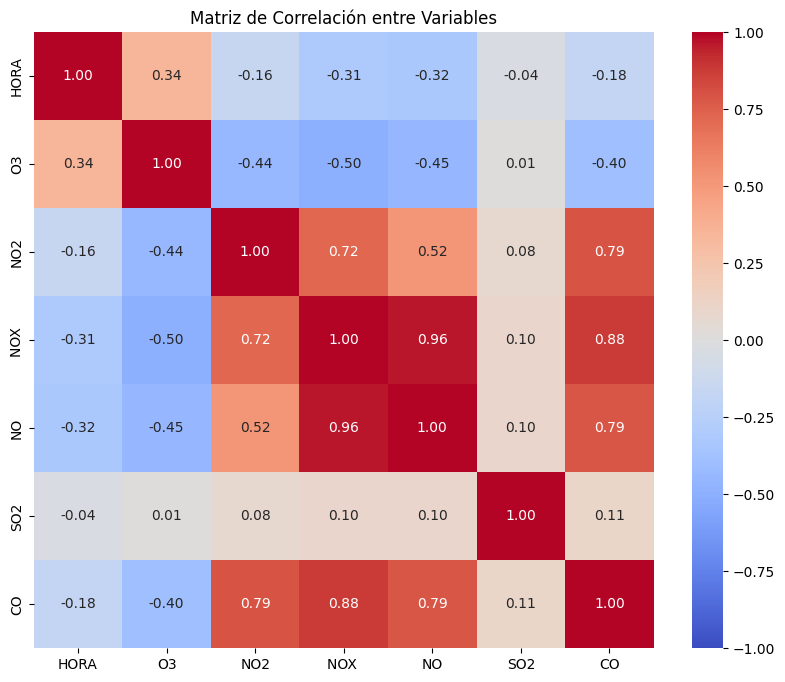

In [54]:
# Como tenermos muchos valores NAN, especialmente en el S02, lo recomendable es aplicar un método para
# llenar estos valores.

import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación (usando Pearson)

columnas_numericas = ['HORA', 'O3', 'NO2', 'NOX ', 'NO', 'SO2', 'CO']
correlacion = df_estudio[columnas_numericas].corr()

# Crear un heatmap interactivo
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Matriz de Correlación entre Variables")
plt.show()

In [55]:
#Observamos que S02 no tiene una gran correlación en entre nuestras variables, por lo cual se usará
# una imputación temporal, medida por hora, además que en las demás usaremos el método de K-vecinos

from sklearn.impute import KNNImputer

# Variables correlacionadas + HORA (para contexto temporal)


variables_correlacionadas = ["NO", "NOX ", "NO2", "CO", "HORA"]
imputador_knn = KNNImputer(n_neighbors=5)

# Aplicar imputación
df_imputado_knn = pd.DataFrame(
    imputador_knn.fit_transform(df_estudio[variables_correlacionadas]),
    columns=variables_correlacionadas,
    index=df_estudio.index # Asegura que df_imputado_knn tenga el mismo índice que df_estudio
)

#Agregar FECHA
df_imputado_knn["FECHA"] = df_estudio["FECHA"]

# Agrupar por hora y calcular la mediana de SO2 para cada hora
mediana_so2_por_hora = df_estudio.groupby("HORA")["SO2"].transform("median")
# Imputar SO2 usando la mediana horaria
df_imputado_knn["SO2"] = df_estudio["SO2"].fillna(mediana_so2_por_hora)
# Si aún quedan NaN, usar la mediana global
df_imputado_knn["SO2"] = df_imputado_knn["SO2"].fillna(df_imputado_knn["SO2"].median())


# Si O3 tiene correlaciones moderadas, usar KNN con variables relacionadas
mediana_o3_por_hora = df_estudio.groupby("HORA")["O3"].transform("median")
df_imputado_knn["O3"] = df_estudio["O3"].fillna(mediana_o3_por_hora)


In [56]:
# Trabajaremos ahora con la base de datos ya limpiada

faltanteO3 = df_imputado_knn['O3'].isnull().sum()
faltanteNO2 = df_imputado_knn['NO2'].isnull().sum()
faltanteCO = df_imputado_knn['CO'].isnull().sum()
faltanteSO2 = df_imputado_knn['SO2'].isnull().sum()
faltanteNOX = df_imputado_knn['NOX '].isnull().sum()
faltanreNO = df_imputado_knn['NO'].isnull().sum()


print(f'Faltantes O3: {faltanteO3}')
print(f'Faltantes NO2: {faltanteNO2}')
print(f'Faltantes CO: {faltanteCO}')
print(f'Faltantes SO2: {faltanteSO2}')
print(f'Faltantes NOX: {faltanteNOX}')
print(f'Faltantes NO: {faltanreNO}')

Faltantes O3: 0
Faltantes NO2: 0
Faltantes CO: 0
Faltantes SO2: 0
Faltantes NOX: 0
Faltantes NO: 0


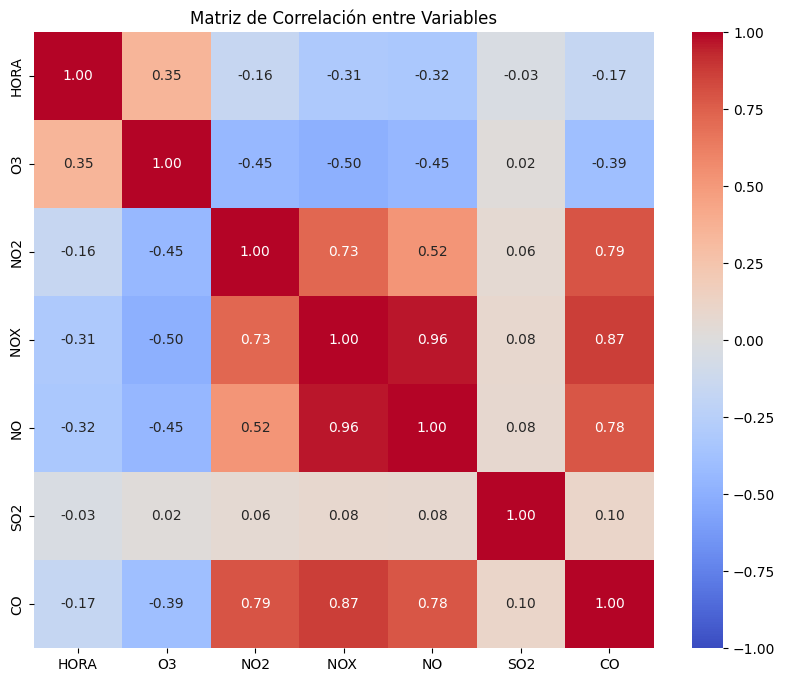

In [57]:
# Calcular la matriz de correlación
correlacion = df_imputado_knn[['HORA', 'O3', 'NO2', 'NOX ','NO', 'SO2', 'CO']].corr()

# Crear un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Matriz de Correlación entre Variables")
plt.show()

In [58]:
columnas_ordenadas = ["FECHA"] + variables_correlacionadas + ["SO2", "O3"]
df_imputado_knn = df_imputado_knn[columnas_ordenadas]

In [59]:
df_muestra_10_porciento = df_imputado_knn.sample(frac=0.1)

In [13]:
# descargar el archivo al 10%
# df_muestra_10_porciento.to_csv('muestra_10_porciento.csv', index=False, encoding='utf-8')

## Implementación del Modelo

In [46]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [81]:
#descargar 10% de los datos de CONTAMINATES_BASELIMPIA_2022, si se desea trabajar con un porcentaje y con la base de datos completa.

# df_10_porciento2022 = df_imputado_knn2022.sample(frac=0.1)
# df_10_porciento2022.to_csv('Datos_10porciento2022.csv', index=False, encoding='utf-8')

In [63]:
#####################    Cargar los datos de entrenamiento    #############################################

dato_entrenamiento = pd.read_csv("CONTAMINATES_BASELIMPIA_2022.csv", parse_dates=True, index_col="FECHA")
datos_entre_or = dato_entrenamiento[['O3', 'NO2', 'NOX', 'NO', 'SO2', 'CO']]


In [64]:
# Escalado de datos
scaler = MinMaxScaler(feature_range=(0, 1))    ###transforma los datos en ceros y uno
train_scaled = scaler.fit_transform(datos_entre_or)


In [65]:
# Crear secuencias de temporales, datos para el entrenamiento
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(train_scaled, 60)

In [66]:
# Modelo LSTM
model = Sequential([
    LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2), #evita el sobreajuste
    LSTM(100, return_sequences=False), #return sequences = False nos da la salid final y no toda la secuencia
    Dense(1, activation='relu') #capa final densa,además "relu" evita salidas negativas
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [67]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 100)             │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 123,301 (481.64 KB)

 Trainable params: 123,301 (481.64 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - loss: 0.0292
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - loss: 0.0031
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - loss: 0.0029
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - loss: 0.0028
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - loss: 0.0023
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - loss: 0.0024
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - loss: 0.0025
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - loss: 0.0023
Epoch 9/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - loss: 0.0023
Epoch 10/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - loss: 0.0023
Epoch 11/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - loss: 0.0024
Epoch 12/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - loss: 0.0023
Epoch 13/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - loss: 0.0025
Epoch 14/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - loss: 0.0023
Epoch 15/50
272/272 ━━━━━━━━━

In [23]:
# df_imputado_knn
#df_imputado_knn.to_csv('CONTAMINATES_BASELIMPIA_COMPL.csv', index=False, encoding='utf-8')

In [71]:
# Preparar los datos reales de 2023 para comparación.

#Nota: para usar los datos reales limpios podemos usar nuestro DataFrame que esta dada por nombre df_imputado_knn
# pero si nos intersa cargar la base de datos se puede hacer manualmente


dato_real_2023 = pd.read_csv("CONTAMINATES_BASELIMPIA_COMPL.csv", parse_dates=True, index_col="FECHA")
dato_real_2023 = dato_real_2023.rename(columns={'NOX ': 'NOX'})

real_scaled = scaler.transform(dato_real_2023[['O3', 'NO2', 'NOX', 'NO', 'SO2', 'CO']])

In [72]:
# Crear datos de entrada para predicción
X_real, _ = create_dataset(np.vstack([train_scaled[-60:], real_scaled]), 60)

# Predicciones
predictions_scaled = model.predict(X_real)

# Rellenamos con ceros para las otras 5 columnas faltantes
relleno = np.zeros((len(predictions_scaled), 5))  # porque O3 es una, faltan 5
predictions_con_6 = np.concatenate([predictions_scaled, relleno], axis=1)

# Ahora aplicar el inverse_transform
predictions = scaler.inverse_transform(predictions_con_6)[:, 0]  # solo columna O3

# Datos reales para comparar
real_demand = scaler.inverse_transform(real_scaled)[:, 0]

159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


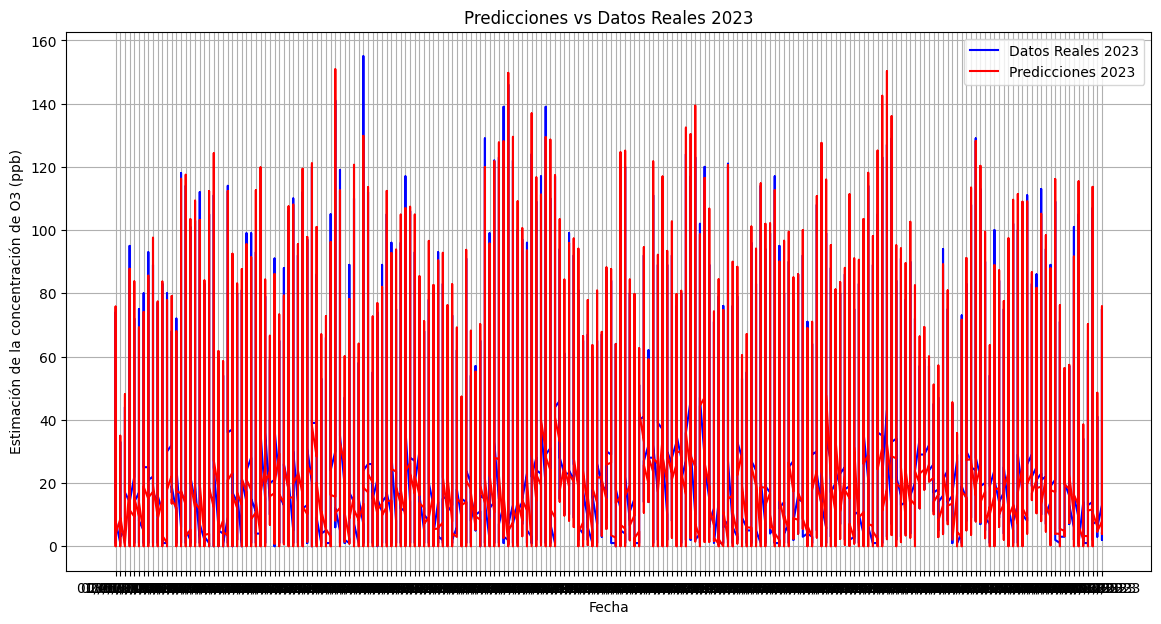

In [74]:

# Graficar
plt.figure(figsize=(14, 7))
plt.plot(dato_real_2023.index, real_demand, label='Datos Reales 2023', color='blue')
plt.plot(dato_real_2023.index[:len(predictions)], predictions, label='Predicciones 2023', color='red')
plt.title('Predicciones vs Datos Reales 2023')
plt.xlabel('Fecha')
plt.ylabel('Estimación de la concentración de O3 (ppb)')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Solo comparamos los primeros len(predictions), para conocer si hay una diferencia signficativa.
y_true = real_demand[:len(predictions)]
y_pred = predictions

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.2f} ppb")
print(f"RMSE: {rmse:.2f} ppb")


MAE: 5.53 ppb
RMSE: 7.96 ppb


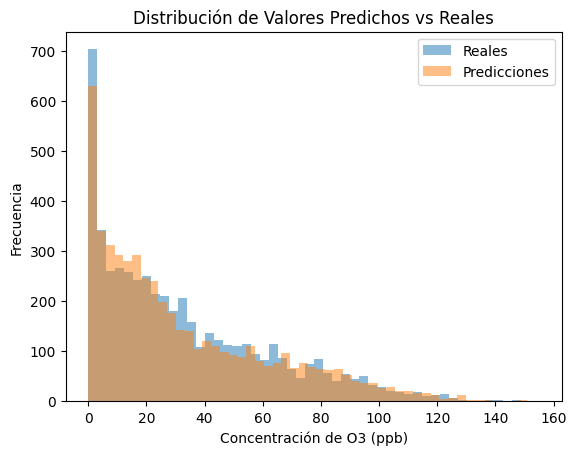

In [80]:
import matplotlib.pyplot as plt

plt.hist(y_true, bins=50, alpha=0.5, label='Reales')
plt.hist(y_pred, bins=50, alpha=0.5, label='Predicciones')
plt.legend()
plt.title('Distribución de Valores Predichos vs Reales')
plt.xlabel('Concentración de O3 (ppb)')
plt.ylabel('Frecuencia')
plt.show()
